# 1. Set Up

In [1]:
!spack find -p tfel
!export PATH=/mofem_install/jupyter/thomas/um_view/bin:$PATH 
!echo $PATH
# !read_med

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages
/mofem_install/um_view/bin:/mofem_install/jupyter/thomas/.local/bin:/mofem_install/jupyter/thomas/.vscode/cli/servers/Stable-e8653663e8840adaf45af01eab5c627a5af81807/server/bin/remote-cli:/mofem_install/um_view/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/py-numpy-1.26.1-ue7volt2h7awnoymiyxjzriegzyc3rr5/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/python-3.11.6-a6ce7p54ivs64b5eohmbbwye227i4642/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/xz-5.4.1-2mwenxme6zkcsocqiwfszexdhxo7zqwt/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwm

In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [4]:
import math
import os
import re
import sys
import time
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gmsh
from scipy import optimize
from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
import calculations as calc

os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
    


# 2. Simulation Parameters

In [ ]:
#in MPa
def initialize_parameters() -> cm.AttrDict:
    params = cm.AttrDict()
    params.global_default_model = cm.PropertyTypeEnum.elastic
    params.tester = cm.TestAttr(
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.le: cm.ElasticProperties(youngs_modulus=233, poisson_ratio=0.499),
            cm.PropertyTypeEnum.vM: cm.VonMisesProperties(youngs_modulus=233, poisson_ratio=0.49, HardeningSlope = 0, YieldStress = 6),
            cm.PropertyTypeEnum.dp: cm.DruckerPragerProperties(youngs_modulus=233, poisson_ratio=0.49, phi=np.radians(27), c=0.001, v=np.radians(27)),
            cm.PropertyTypeEnum.dp_hyperbolic: cm.DruckerPragerHyperbolicProperties(youngs_modulus=233, poisson_ratio=0.49, phi=np.radians(27), c=0.00001, v=np.radians(27), proximity = 0.0000000001),
            cm.PropertyTypeEnum.mcc: cm.CamClayProperties(),
            }, 
        
    )
    params.mesh_size = 10 # mesh is a square, length of the edge
 
    # the prescription is always applied to the max_y edge
    # negative disp/force here is to the positive direction, i.e. if applied -y on the max y edge then extension
    # positive disp here is to the negative direction, i.e. if applied +y on the max y edge then compression
    # params.prescribed_force = cm.ForceBoundaryCondition(f_x=0,f_y=120,fz=None)
    params.prescribed_disp = cm.EdgeBoundaryCondition(disp_uy=0.5)
    # params.time_history = cm.TimeHistory(history = {
    #     0: 0, 
    #     0.25: 0.1, 
    #     0.5: 0.098, 
    #     0.75: 0.15, 
    #     1: 0.1448,
    #     }
    # )
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 2
    # params.time_step = 0.05 # [s]
    params.final_time = 1 # [s]
    params.time_step = 1 / 200 # [s]
    params.case_name = "test_2D"
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.um_view = f"/mofem_install/jupyter/thomas/um_view"
    params.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_2d"
    return params

In [6]:
params = initialize_parameters()

In [7]:
print(params.global_default_model.name)

dp


# 3. Log paths and meta

In [8]:
params = setup.setup(params)

Simulation #1 for the day.


# 4. Generate the mesh

In [9]:
core.generate_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
1
2
3
4
min_x_min_y_node=1 min_x_max_y_node=4 max_x_min_y_node=2 max_x_max_y_node=3 min_x=-5.0 max_x=5.0 min_y=-5.0 max_y=5.0
Done, taken Wall Time: 0.06 seconds, CPU Time: 0.06 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.01 seconds, CPU Time: 0.01 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'test_2D_day_87_sim_1_dp': 1, 'FIX_X_0': 2, 'FIX_X_1': 3, 'FIX_Y_0': 4, 'FIX_Y_2': 5, 'test_2D': 6}
Done, taken Wall Time: 0.41 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
[PhysicalGroup(dim=2, tags=[1], name='test_2D', meshnet_id=6, group_type=<PhysicalGroupType.MATERIAL: 1>, preferred_model=<PropertyTypeEnum.dp: 'DruckerPragerSimple'>, props={<PropertyTypeEnum.le: 'LinearElasticity'>: ElasticProperties(youngs_modulus=233.0, po

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-12 12:56:43
[0] <inform> UTC time: 2024-11-12 12:56:43
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh test_2D_day_87_sim_1_dp nsteps 1
[0] <inform> [MED] Reading mesh test_2D_day_87_sim_1_dp nsteps 1
[0] <inform> [MED] Read number of nodes 1935
[0] <inform> [MED] Reading elements 4 of type Vertex number of nodes 1
[0] <inform> [MED] Reading elements 160 of type Edge number of nodes 2
[0] <inform> [MED] Reading elements 3708 of type Tri number of nodes 3
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_2D_day_87_sim_1_dp
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name

Done, taken Wall Time: 0.37 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 0.33 seconds, CPU Time: 0.00 seconds


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-12 12:56:43
[0] <inform> UTC time: 2024-11-12 12:56:43
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_2D_day_87_sim_1_dp
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_X_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_Y_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_Y_2                        
[0] <inform> [MeshsetMng] meshset in

{'global_default_model': <PropertyTypeEnum.dp: 'DruckerPragerSimple'>,
 'tester': TestAttr(preferred_model=<PropertyTypeEnum.dp: 'DruckerPragerSimple'>, props={<PropertyTypeEnum.le: 'LinearElasticity'>: ElasticProperties(youngs_modulus=233.0, poisson_ratio=0.499), <PropertyTypeEnum.vM: 'VMSimo'>: VonMisesProperties(youngs_modulus=233.0, poisson_ratio=0.49, HardeningSlope=0.0, YieldStress=6.0), <PropertyTypeEnum.dp: 'DruckerPragerSimple'>: DruckerPragerProperties(youngs_modulus=233.0, poisson_ratio=0.49, phi=0.47123889803846897, c=0.001, v=0.47123889803846897), <PropertyTypeEnum.dp_hyperbolic: 'DruckerPragerHyperboloidal'>: DruckerPragerHyperbolicProperties(youngs_modulus=233.0, poisson_ratio=0.49, phi=0.47123889803846897, c=1e-05, v=0.47123889803846897, proximity=1e-10), <PropertyTypeEnum.mcc: 'ModCamClay_semiExpl'>: CamClayProperties(nu=0.3, M=1.2, la=0.077, ka=0.0066, v0=1.7857, pc0=400)}),
 'mesh_size': 10,
 'prescribed_disp': EdgeBoundaryCondition(disp_ux=None, disp_uy=0.5, disp_uz

# 5. Running the analysis and export to .vtk file format

In [10]:
core.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
Command:
['bash', '-c', 'export OMPI_MCA_btl_vader_single_copy_mechanism=none && nice -n 10 mpirun --oversubscribe --allow-run-as-root -np 8 /mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_2d -file_name /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_87_sim_1_20241112_125642_dp/test_2D_day_87_sim_1_dp_8p.h5m -sdf_file /mofem_install/jupyter/thomas/mfront_example_test/src/sdf.py -order 2 -contact_order 0 -sigma_order 0 -ts_dt 0.005 -ts_max_time 1 -mi_lib_path_106 /mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so -mi_block_106 DruckerPragerSimple -mi_param_106_0 0.47123889803846897 -mi_param_106_1 0.001 -mi_param_106_2 233.0 -mi_param_106_3 0.49 -mi_param_106_4 0 -mi_param_106_5 0  -mi_save_volume 1 -mi_save_gauss 0 ']
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <info

SystemExit: 1

/mofem_install/jupyter/thomas/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
core.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯
Conversion to VTK successful.
Moved out_mi_81.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_93.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_80.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_92.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_7.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_8.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks
Moved out_mi_91.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulati

# 6. Visualize final time step .vtk file

/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/vtks/out_mi_200.vtk
['GLOBAL_ID', 'DISPLACEMENT', 'STRAIN', 'STRESS', 'GLOBAL_ID', 'PARALLEL_PARTITION']


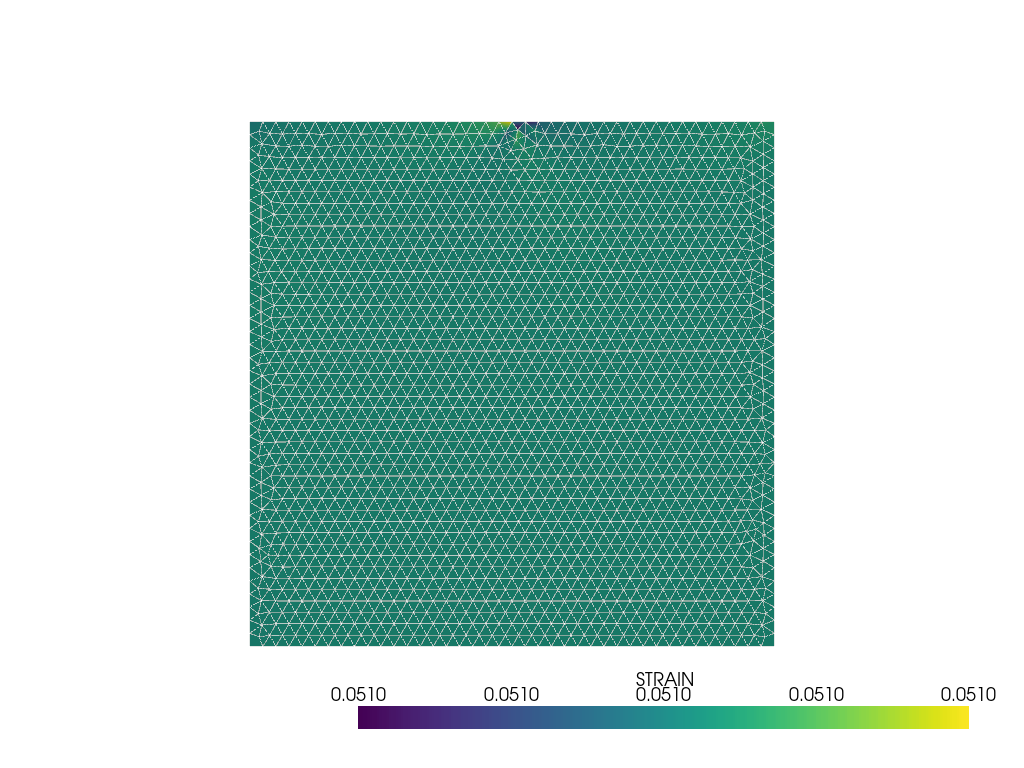

In [ ]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.vtk_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    print(final_file)
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    print(mesh.array_names)
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "DISPLACEMENT"
    show_field = "STRAIN" # U: displacement
    # show_field = "STRESS" # U: displacement
    
    if mesh.point_data[show_field].shape[1] > 3:
        cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.add_mesh(mesh, scalars="STRAIN")
    p.camera_position = 'xy'
    p.show(jupyter_backend='ipygany')
    p.screenshot(f"{params.graph_dir}/_strain.png")
    p.clear()
    p.add_mesh(mesh, scalars="STRESS")
    p.camera_position = 'xy'
    p.screenshot(f"{params.graph_dir}/_stress.png")
    p.clear()
    p.add_mesh(mesh, scalars="DISPLACEMENT")
    p.camera_position = 'xy'
    p.screenshot(f"{params.graph_dir}/_displacement.png")
    p.clear()
    
    

# 7. Extract data from .vtk files 
Tools:
pvpython

In [ ]:
paraview_path = "/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython"

original_pythonpath = os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] = ""
# Properly format the command in Python
# Construct the command as a list of strings

@ut.track_time("PULLING A SELECTED POINT OVER TIME WITH pvpython")
def to_csv():
    command = [
        paraview_path,
        "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/point_to_time_csv.py",
        params.vtk_dir,
        params.point_to_time_filepath,
        str(int(params.mesh_size/2)),
        str(int(params.mesh_size/2)),
        str(0),
    ]
    # Run the command using subprocess
    try:
        process = subprocess.run(command, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
    # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath
        
to_csv()
df = pd.read_csv(params.point_to_time_filepath)
strain_magnitude = np.array(df['avg(STRAIN (Magnitude))'])
color_max = strain_magnitude.max()
color_min = strain_magnitude.min()

@ut.track_time("ANIMATING OVER TIME WITH pvpython")
def animate():
    command = [
        paraview_path,
        "/mofem_install/jupyter/thomas/mfront_example_test/src/pvpython_scripts/test_2D_animate.py",
        params.vtk_dir,
        params.strain_animation_filepath_png,
        str(color_min),
        str(color_max),
    ]
    # Run the command using subprocess
    try:
        process = subprocess.run(command, check=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e.stderr.decode())
    finally:
    # Restore the original PYTHONPATH
        os.environ["PYTHONPATH"] = original_pythonpath

#Stitch together animations
@ut.track_time("STITCHING .pngs TOGETHER with ffmpeg")
def create_mp4_from_png_sequence(animation_filepath_png_ffmpeg_regex, animation_filepath_mp4, framerate=40):
    # Build the ffmpeg command
    ffmpeg_command = [
        '/mofem_install/jupyter/thomas/ffmpeg-7.0.2-amd64-static/ffmpeg',
        '-framerate', str(framerate),  # Set input framerate
        '-y',
        '-i', animation_filepath_png_ffmpeg_regex,  # Input image sequence (with regex pattern)
        '-c:v', 'libx264',  # Set video codec to libx264
        '-pix_fmt', 'yuv420p',  # Set pixel format for compatibility
        '-loglevel', 'warning',
        animation_filepath_mp4  # Output .mp4 file
    ]

    # Run the ffmpeg command as a subprocess
    try:
        subprocess.run(ffmpeg_command, check=True, capture_output=True)
        print(f"MP4 video created successfully: {animation_filepath_mp4}")
    except subprocess.CalledProcessError as e:
        print(f"Error occurred during ffmpeg execution: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

animate()
create_mp4_from_png_sequence(params.strain_animation_filepath_png_ffmpeg_regex, params.strain_animation_filepath_mp4, framerate=40)


╭────────────────────────────────────────────────────╮
│  PULLING A SELECTED POINT OVER TIME WITH pvpython  │
╰────────────────────────────────────────────────────╯
Done, taken Wall Time: 17.75 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  ANIMATING OVER TIME WITH pvpython  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 79.13 seconds, CPU Time: 0.00 seconds
╭────────────────────────────────────────╮
│  STITCHING .pngs TOGETHER with ffmpeg  │
╰────────────────────────────────────────╯
MP4 video created successfully: /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/test_2D_day_86_sim_57_vM.mp4
Done, taken Wall Time: 1.65 seconds, CPU Time: 0.00 seconds


# 8. Plotting
Tools:
Matplotlib and pandas

'/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_2D_day_86_sim_57_20241111_173806_vM/graphs/304_ev_ed.png'

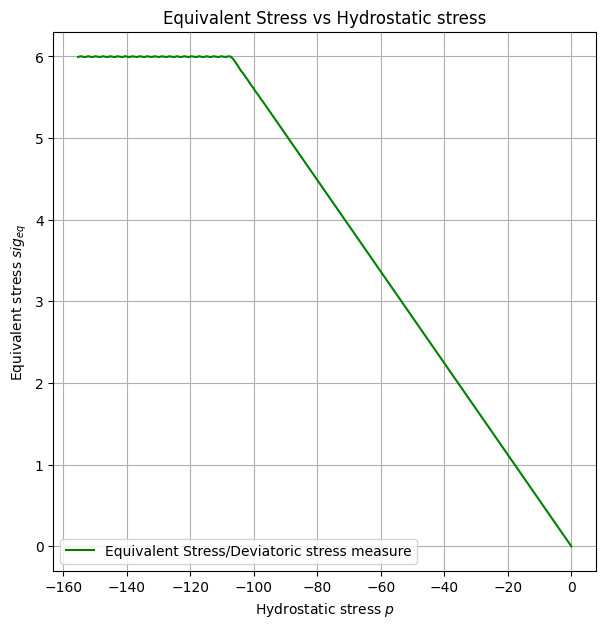

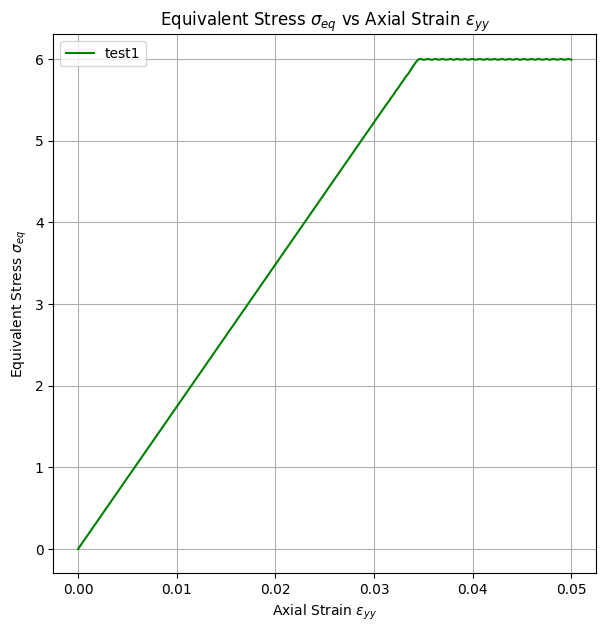

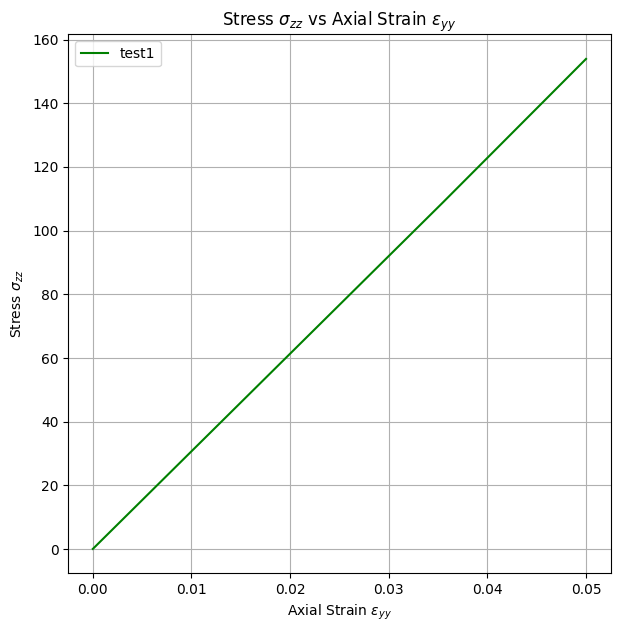

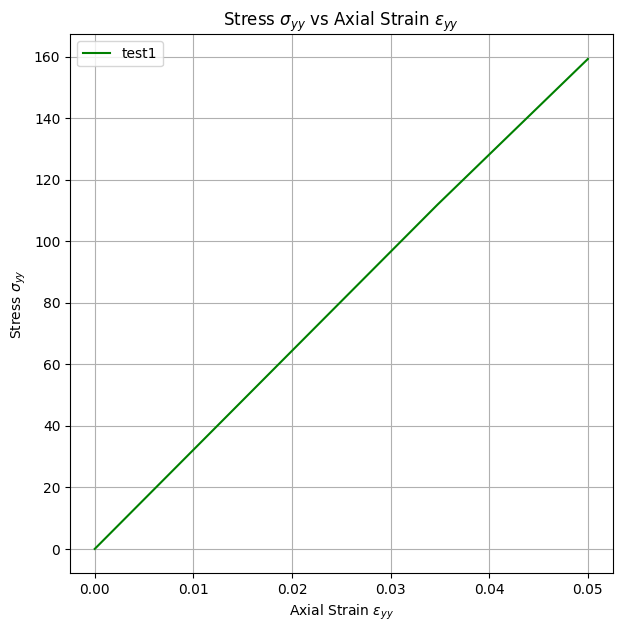

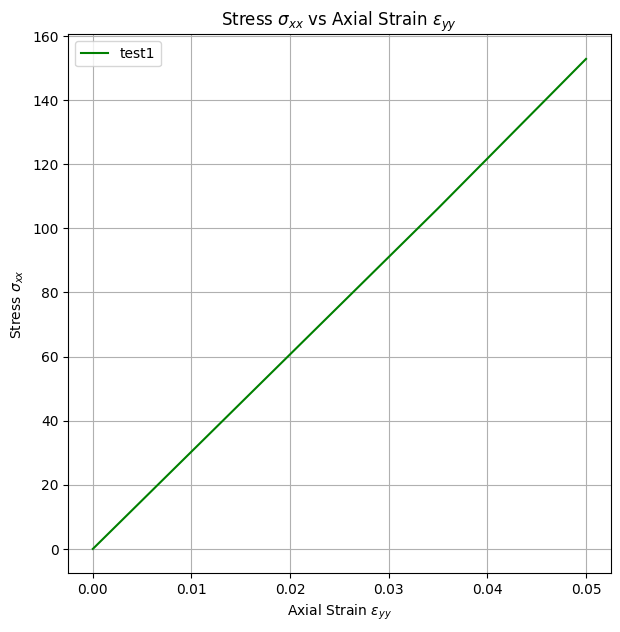

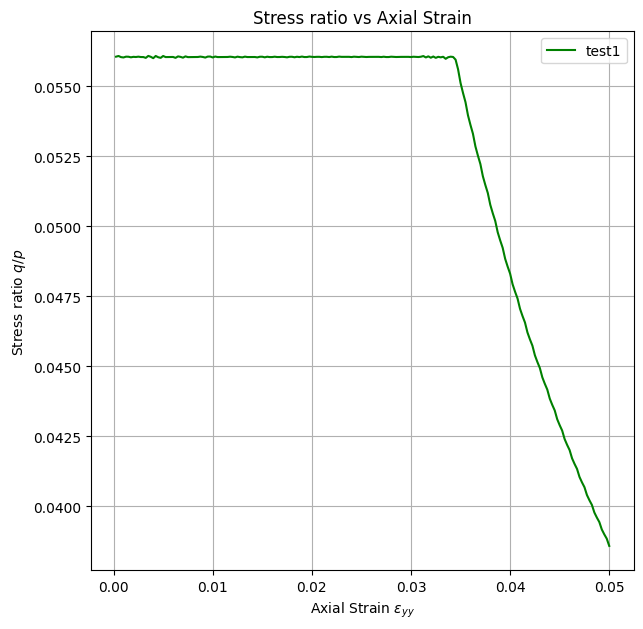

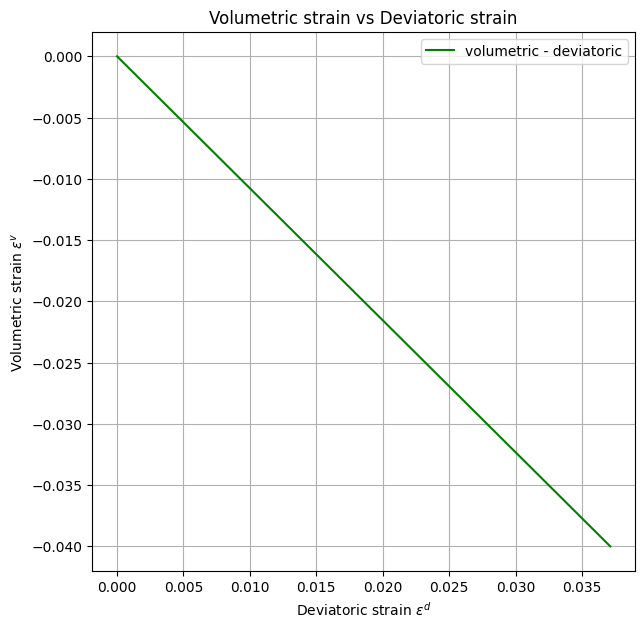

In [ ]:
import sys

import matplotlib
import numpy as np
sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import plotting
import calculations as calc


matplotlib.rc('figure', figsize=(7, 7))
import pandas as pd
df = pd.read_csv(params.point_to_time_filepath)
# use geotechnics convention of positive stress/strain = compression, check output to make sure
sig_xx = np.array(df['max(STRESS (0))'])
sig_xy = np.array(df['max(STRESS (1))'])
sig_xz = np.array(df['max(STRESS (2))'])
sig_yy = np.array(df['max(STRESS (4))'])
sig_yz = np.array(df['max(STRESS (5))'])
sig_zz = np.array(df['max(STRESS (8))'])


e_xx = np.array(df['max(STRAIN (0))'])
e_xy = np.array(df['max(STRAIN (1))'])
e_xz = np.array(df['max(STRAIN (2))'])
e_yy = np.array(df['max(STRAIN (4))'])
e_yz = np.array(df['max(STRAIN (5))'])
e_zz = np.array(df['max(STRAIN (8))'])

sig_1, sig_2, sig_3 = calc.calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)
p = calc.calculate_p(sig_1, sig_2, sig_3)
J_2 = calc.calculate_J2(sig_1, sig_2, sig_3)
J  = np.sqrt(J_2)
tau_oct = np.sqrt(2 * J_2)
sig_eq = np.sqrt(3 * J_2)
e_v, e_d = calc.calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)

def plot_x_ys(x_array: list, y_arrays, labels: list, cutoffs=None, x_label="", y_label="", title="", save_as: str = None):
    data = []
    for i in range(len(y_arrays)):
        data.append((x_array, y_arrays[i], labels[i], 'g', None))
    return plotting.create_plot(data, x_label, y_label, title, save_as)

plot_x_ys(p, [sig_eq], labels=["Equivalent Stress/Hydrostatic stress"], x_label='Hydrostatic stress $p$', y_label='Equivalent stress $sig_{eq}$', title='Equivalent Stress vs Hydrostatic stress', save_as = f"{params.graph_dir}/111_sigeq_p.png")

plot_x_ys(-e_yy, [sig_eq], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Equivalent Stress $\sigma_{eq}$', title='Equivalent Stress $\sigma_{eq}$ vs Axial Strain $\epsilon_{yy}$', save_as = f"{params.graph_dir}/201_sigeq_eyy.png")
plot_x_ys(-e_yy, [sig_zz], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress $\sigma_{zz}$', title='Stress $\sigma_{zz}$ vs Axial Strain $\epsilon_{yy}$', save_as = f"{params.graph_dir}/201_sigeq_ezz.png")
plot_x_ys(-e_yy, [sig_yy], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress $\sigma_{yy}$', title='Stress $\sigma_{yy}$ vs Axial Strain $\epsilon_{yy}$', save_as = f"{params.graph_dir}/201_sigeq_eyy.png")
plot_x_ys(-e_yy, [sig_xx], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress $\sigma_{xx}$', title='Stress $\sigma_{xx}$ vs Axial Strain $\epsilon_{yy}$', save_as = f"{params.graph_dir}/201_sigeq_exx.png")

plot_x_ys(-e_yy[1:], [sig_eq[1:]/p[1:]], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{params.graph_dir}/211_sigeq_div_p_eyy.png")

plot_x_ys(e_d, [e_v], labels=["volumetric - deviatoric"], x_label='Deviatoric strain $\epsilon^d$', y_label='Volumetric strain $\epsilon^v$', title='Volumetric strain vs Deviatoric strain', save_as = f"{params.graph_dir}/304_ev_ed.png")
# plotting.plot_2d_with_animation(-e_yy, sig_eq, 'Axial Strain $\epsilon_{zz}$', 'Equivalent Stress $\sigma_{eq}$', '$\sigma_{eq}$ - Axial Strain $\epsilon_{zz}$', save_as=f"{params.data_dir}/41_sigeq_ezz")
# plot_x_ys(-e_yy, [sig_eq/(p)], labels=["test1"], x_label='Axial Strain $\epsilon_{yy}$', y_label='Stress ratio $q/p$', title='Stress ratio vs Axial Strain', save_as = f"{params.data_dir}/2_sigeq_div_p_eyy.png")
